In [23]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.utils import *
from tensorflow.keras.initializers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time, random

In [2]:
#Hyperparameters
batch_size = 64
latent_dim = 256
num_samples = 10000

In [3]:
#Vectorize the data.
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

In [4]:
with open('fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_chars:
            input_chars.add(char)
    for char in target_text:
        if char not in target_chars:
            target_chars.add(char)

In [5]:
input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [6]:
#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


In [7]:
#Define data for encoder and decoder
input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_in_data[i, t, input_token_id[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_in_data[i, t, target_token_id[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_id[char]] = 1.

In [8]:
#Define and process the input sequence
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [9]:
#Using `encoder_states` set up the decoder as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [10]:
#Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [11]:
#Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 93)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [12]:
#Model data Shape
print("encoder_in_data shape:",encoder_in_data.shape)
print("decoder_in_data shape:",decoder_in_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_in_data shape: (10000, 16, 71)
decoder_in_data shape: (10000, 59, 93)
decoder_target_data shape: (10000, 59, 93)


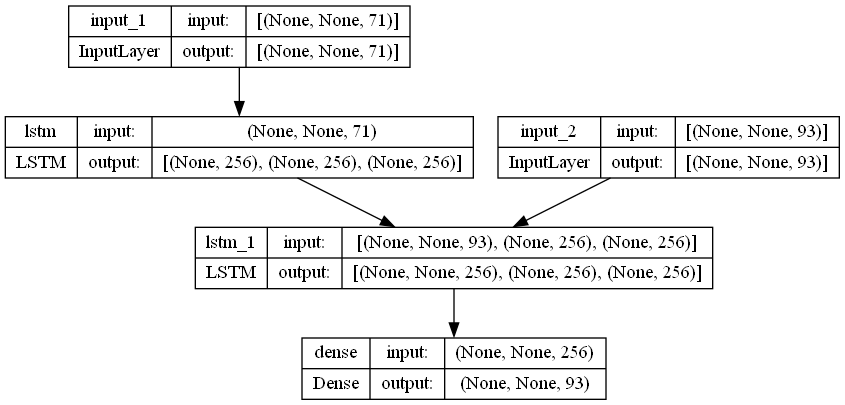

In [13]:
#Visuaize the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [51]:
#Compiling and training the model
opt = tf.keras.optimizers.legacy.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy')

c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [52]:
model.fit([encoder_in_data, decoder_in_data], decoder_target_data, batch_size=batch_size, epochs=50, validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 37s 273ms/step - loss: 0.6597 - val_loss: 0.6931
Epoch 2/50
125/125 [==============================] - 40s 320ms/step - loss: 0.6641 - val_loss: 1.1304
Epoch 3/50
125/125 [==============================] - 28s 224ms/step - loss: 0.9088 - val_loss: 1.0441
Epoch 4/50
125/125 [==============================] - 36s 287ms/step - loss: 0.8127 - val_loss: 0.9539
Epoch 5/50
125/125 [==============================] - 27s 219ms/step - loss: 0.7043 - val_loss: 0.8015
Epoch 6/50
125/125 [==============================] - 25s 201ms/step - loss: 0.6239 - val_loss: 0.7443
Epoch 7/50
125/125 [==============================] - 24s 195ms/step - loss: 0.6669 - val_loss: 0.8746
Epoch 8/50
125/125 [==============================] - 33s 263ms/step - loss: 0.7185 - val_loss: 0.8754
Epoch 9/50
125/125 [==============================] - 31s 245ms/step - loss: 0.6944 - val_loss: 0.8196
Epoch 10/50
125/125 [==============================] - 29s 234ms/step - l

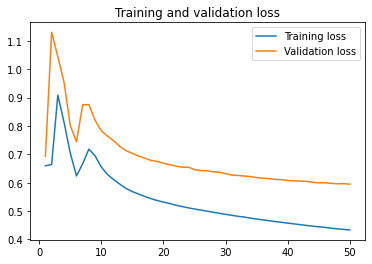

In [53]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [54]:
# Save the model 
model.save('s2s.h5')

In [55]:
#Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

In [56]:
#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Get the first character of target sequence with the start character.
    target_seq[0, 0, target_token_id['\t']] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence

In [57]:
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Translator:', decoded_sentence)

1/1 [==============================] - 0s 56ms/step
-
Input sentence: Go.
Translator: Commes antent !

1/1 [==============================] - 0s 53ms/step
-
Input sentence: Run!
Translator: Allez !

1/1 [==============================] - 0s 56ms/step
-
Input sentence: Run!
Translator: Allez !

1/1 [==============================] - 0s 53ms/step
-
Input sentence: Wow!
Translator: Que vous en pas !

1/1 [==============================] - 0s 47ms/step
-
Input sentence: Fire!
Translator: Sais-tou !

1/1 [==============================] - 0s 76ms/step
-
Input sentence: Help!
Translator: Aidez-moi !

1/1 [==============================] - 0s 66ms/step
-
Input sentence: Jump.
Translator: Va te la mais.

1/1 [==============================] - 0s 73ms/step
-
Input sentence: Stop!
Translator: Arrête de la pas !

1/1 [==============================] - 0s 59ms/step
-
Input sentence: Stop!
Translator: Arrête de la pas !

1/1 [==============================] - 0s 60ms/step
-
Input sentence: Stop!
Tr